In [1]:
import os
import time
import vtk
import numpy as np
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams['svg.fonttype'] = 'none'
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage, writers
from aicscytoparam import cytoparam
from scipy import interpolate as sciinterp
from skimage import io as skio
from skimage import segmentation as skseg
import concurrent
from tqdm.notebook import tqdm
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
from cell_shape_variation.steps.analysis import analysis_tools as atools
from cell_shape_variation.steps.shapemode import avgshape
from nuclear_shape_analysis_workflow.steps.make_feature_figures import make_feature_figures_utils as figtools

In [2]:
out = '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/local_staging/notebooks/fig_cytoparam'

In [3]:
staging_folder = 'local_staging'

path_to_csv = f'/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/{staging_folder}/shapemode/manifest.csv'

df = pd.read_csv(path_to_csv, index_col=0)

print(f'CSV shape: {df.shape}, last modified: {time.ctime(os.path.getctime(path_to_csv))}')

/home/matheus.viana/anaconda3/envs/variation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (31,35,37,42,43,44,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


CSV shape: (203764, 831), last modified: Fri Nov 20 00:56:39 2020


In [4]:
# Create map points, bins e get all cells in each bin
_, bin_indexes, _ = avgshape.digitize_shape_mode(
    df = df,
    feature = 'DNA_MEM_PC1',
    nbins = 9
)

# Parameterization example

In [ ]:
index = df.loc[(df.index.isin(bin_indexes[4][1]))&(df.structure_name=='LMNB1')].index[12]
print(index)
# index = 718517
row = df.loc[index]

In [ ]:
raw = AICSImage(row['crop_raw']).get_image_data("CZYX", S=0, T=0)

ch_seg_nuc = eval(row['name_dict'])['crop_seg'].index('dna_segmentation')
ch_seg_mem = eval(row['name_dict'])['crop_seg'].index('membrane_segmentation')
ch_seg_str = eval(row['name_dict'])['crop_seg'].index('struct_segmentation')
seg = AICSImage(row['crop_seg']).get_image_data("CZYX", S=0, T=0, C=[ch_seg_nuc, ch_seg_mem, ch_seg_str])

print(f'\tDNA ch: {ch_seg_nuc}, MEM ch: {ch_seg_mem}, STR ch: {ch_seg_str}. SEG shape {seg.shape}')

In [ ]:
reload(cytoparam)

# Perform 2d alignment
seg, params = shtools.align_image_2d(image=seg, alignment_channel=1, preserve_chirality=True)

# Apply alignemnt to raw data
raw = shtools.apply_image_alignment_2d(
    image = raw,
    angle = params[0],
    flip_x = int(params[1]),
    flip_y = int(params[2])
)

# Test reconstruction
meshes, traces, (projs, projs_rec), pcorr = cytoparam.evaluate_reconstruction(
    seg_nuc = seg[0],
    seg_mem = seg[1],
    image_to_probe = seg[-1],
    array_name = 'intensity'
)

In [ ]:
# Save meshes and traces
shtools.save_polydata(traces, f'{out}/trace.vtk')
for m, mesh in enumerate(meshes):
    shtools.save_polydata(mesh, f'{out}/mesh{m:02d}.vtk')

# Save projections
writer = writers.OmeTiffWriter(f'{out}/projs.tif', overwrite_file=True)
writer.save(projs.astype(np.uint16), dimension_order='CZYX')

# Save projections of reconstruction
writer = writers.OmeTiffWriter(f'{out}/projs_rec.tif', overwrite_file=True)
writer.save(projs_rec.astype(np.uint16), dimension_order='CZYX')

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(8,8))
trc_scalar = vtk_to_numpy(traces.GetPointData().GetArray('intensity'))
code = []
for level in np.split(trc_scalar, 66*132+2):
    grid = level[1:].reshape(1,64)
    code.append(grid)
code = np.concatenate(code, axis=0)[-150:]
code = np.clip(code, *np.percentile(code,[10,99]))
ax.imshow(code, cmap='gray')
ax.axis('off')
plt.show()

In [6]:
list_of_dfs = [df.loc[(df.index.isin(bin_indexes[4][1]))&(df.structure_name==sname)].sample(n=32) for sname in df.structure_name.unique()]

In [11]:
reload(cytoparam)

def evaluate_this_structure(df_input):

    result = []
    for index, row in df_input.iterrows():
        print(index)
        raw = AICSImage(row['crop_raw']).data.squeeze()
        ch_seg_nuc = eval(row['name_dict'])['crop_seg'].index('dna_segmentation')
        ch_seg_mem = eval(row['name_dict'])['crop_seg'].index('membrane_segmentation')
        ch_seg_str = eval(row['name_dict'])['crop_seg'].index('struct_segmentation')
        seg = AICSImage(row['crop_seg']).data.squeeze()
        seg = seg[[ch_seg_nuc, ch_seg_mem, ch_seg_str]]
        
        try:
            meshes, traces, (projs, projs_rec), pcorr = cytoparam.evaluate_reconstruction(
                seg_nuc = seg[0],
                seg_mem = seg[1],
                image_to_probe = raw[2], # << seg or raw
                array_name = 'intensity'
            )

            sname = df_input.structure_name.unique()[0]
            result.append({'CellId': index, 'structure_name': sname, 'correlation': pcorr})
        except:
            print(f'Problematic ID:{index}')
            pass
        
    return result

# for df_input in tqdm(list_of_dfs[::-1][4:]):
#     evaluate_this_structure(df_input)

with concurrent.futures.ProcessPoolExecutor(15) as executor:
    result = list(tqdm(executor.map(evaluate_this_structure, list_of_dfs), total=len(list_of_dfs)))
    
df_result = pd.concat([pd.DataFrame(res) for res in result])
df_result = df_result.set_index('CellId')
df_result = df_result.groupby('structure_name').agg(['mean','std'])
df_result = df_result.sort_values(by=[('correlation','mean')])
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.bar(df_result.index, df_result[('correlation','mean')], yerr=df_result[('correlation','std')], facecolor='gray')
ax.tick_params(axis='x', which='major', labelsize=14, rotation=90)
ax.set_ylabel('Voxelwise Pearson correlation', fontsize=18)
ax.set_ylim(0,1)
plt.savefig(f'{out}/pearson_n32_raw_SM1B4.svg', format='svg', bbox_inches = "tight")
plt.show()

404329
435959
504044
555597
917301
966305
294217
730781
650434
740575
659643
993724
441716
348573
386829
785148
397243
499361
373002
654177
990926
296249
528791
412754
338188
829349
611220
678706
642636
526852
506258
822267
399561
388303
718991
518066
684545
625346
765771
991866
279695
326476
661709
528497
977444
455411
623807
749968
241131
651408
956322
434184
528713
695929
694458
995533
313899
593574
331004
250986
611262
581446
516956
527117
387381
752260
745817
664804
573822
1001659
511174
624042
727054
292616
458949
625222
604236
245714
346810
387166
765767
902272
857345
530142
996182
310663
753094
514087
558366
714236
524714
742319
820135
853397
383977
239099
316256
794363
709458
532564
314486
1002817
979911
376169
505830
720660
445926
831342
429974
508111
334755
243543
578467
849637
296735
Problematic ID:376169
377762
691285
991219
618211
840518
447466
688350
343838
430471
570324
837554
303287
251727
726263
372713
501553
533509
787310
1002491
765462
318743
277870
745949
487754
41

# Parameterization of a particular shape mode

In [ ]:
shapemode = AICSImage('/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/assay-dev-cytoparam/avgcell/DNA_MEM_PC1_seg_avg.tif')
shapemode = shapemode.data.squeeze()
print(shapemode.shape)

In [ ]:
selected_bin = 5

In [ ]:
mem_sm = (shapemode[-1,:,selected_bin-1]>0).astype(np.uint8)
nuc_sm = (shapemode[-1,:,selected_bin-1]>1).astype(np.uint8)

mem_sm = np.pad(mem_sm, ((0,0),(3,3),(3,3)))
nuc_sm = np.pad(nuc_sm, ((0,0),(3,3),(3,3)))

# Run parameterization
meshes_sm, traces_sm = cytoparam.parametrize(
    seg_mem = mem_sm,
    seg_nuc = nuc_sm
)

In [ ]:
# shtools.save_polydata(traces_sm, f'{out}/trace.vtk')
# for m, mesh in enumerate(meshes_sm):
#     shtools.save_polydata(mesh, f'{out}/mesh{m:02d}.vtk')
# print(f'\tComplete.')

# Copy content from previous id to the shape mode and voxelize

In [ ]:
traces_sm = cytoparam.copy_content(
    sources = [f'{out}/trace.vtk'],
    destination = traces_sm,
    arrays=['intensity']
)

In [ ]:
trc_coords = vtk_to_numpy(traces_sm.GetPoints().GetData())
trc_scalar = vtk_to_numpy(traces_sm.GetPointData().GetArray('intensity_avg'))

nninterpolator = sciinterp.NearestNDInterpolator(trc_coords[:,[2,1,0]],trc_scalar)

In [ ]:
cytopts = np.where(mem_sm)

field = np.zeros(mem_sm.shape, dtype=np.float32)
field[trc_coords[:,2].astype(np.int),trc_coords[:,1].astype(np.int),trc_coords[:,0].astype(np.int)] = trc_scalar
field[mem_sm==0] = 0

field_interp = field.copy()
field_interp[cytopts] = nninterpolator(cytopts)

In [ ]:
z, y, _ = np.where(nuc_sm)
zs = 1+int(z.max())
ys = int(y.mean())

projs_param = np.array([
    np.vstack([mem_sm[zs],mem_sm[:,ys][::-1]]),
    np.vstack([nuc_sm[zs],nuc_sm[:,ys][::-1]]),
    np.vstack([field[zs],field[:,ys][::-1]]),
    np.vstack([field_interp[zs],field_interp[:,ys][::-1]]),
    np.vstack([mem_sm.max(axis=0),mem_sm.max(axis=1)[::-1]]),
    np.vstack([nuc_sm.max(axis=0),nuc_sm.max(axis=1)[::-1]]),
    np.vstack([field.max(axis=0),field.max(axis=1)[::-1]]),
    np.vstack([field_interp.max(axis=0),field_interp.max(axis=1)[::-1]])
])

writer = writers.OmeTiffWriter(f'{out}/projs_morph.tif', overwrite_file=True)
writer.save(projs_param.astype(np.uint16), dimension_order='CZYX')

# Working on aggregated cells

In [6]:
shape_mode = 3
scalar_type = 'seg'
avgcell_dir = '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/assay-dev-cytoparam/avgcell'
structures_list = ['CETN2','TUBA1B','PXN','TJP1','LMNB1','NUP153','ST6GAL1','LAMP1','ACTB','DSP','FBL','NPM1','TOMM20','SLC25A17','ACTN1','GJA1','HIST1H2BJ','SON','SEC61B','RAB5A','MYH10','AAVS1','CTNNB1','ATP2A2','SMC1A','DOMAIN']

In [283]:
avg_img = AICSImage(os.path.join(avgcell_dir, f'DNA_MEM_PC{str(shape_mode)}_{scalar_type}_avg.tif')).data.squeeze()
std_img = AICSImage(os.path.join(avgcell_dir, f'DNA_MEM_PC{str(shape_mode)}_{scalar_type}_std.tif')).data.squeeze()
cva_img = AICSImage(os.path.join(avgcell_dir, f'DNA_MEM_PC{str(shape_mode)}_{scalar_type}_cva_regularization.tif')).data.squeeze()
print('AVG:', avg_img.shape, avg_img.min(), avg_img.max(), avg_img.dtype)
print('STD:', std_img.shape, std_img.min(), std_img.max(), std_img.dtype)
print('CVA:', cva_img.shape, cva_img.min(), cva_img.max(), cva_img.dtype)

AVG: (26, 97, 9, 128, 256) 0.0 244.17 float32
STD: (26, 97, 9, 128, 256) 0.0 127.501 float32
CVA: (26, 9, 97, 128, 256) 0.0 35.51059 float32


In [284]:
avg_img = np.swapaxes(avg_img,1,2)
std_img = np.swapaxes(std_img,1,2)
# cva_img = np.swapaxes(cva_img,1,2)

avg_img = np.pad(avg_img, ((0,0),(0,0),(0,0),(3,3),(3,3)))
std_img = np.pad(std_img, ((0,0),(0,0),(0,0),(3,3),(3,3)))
cva_img = np.pad(cva_img, ((0,0),(0,0),(0,0),(3,3),(3,3)))

print('AVG:', avg_img.shape, avg_img.min(), avg_img.max(), avg_img.dtype)
print('STD:', std_img.shape, std_img.min(), std_img.max(), std_img.dtype)
print('CVA:', cva_img.shape, cva_img.min(), cva_img.max(), cva_img.dtype)

AVG: (26, 9, 97, 134, 262) 0.0 244.17 float32
STD: (26, 9, 97, 134, 262) 0.0 127.501 float32
CVA: (26, 9, 97, 134, 262) 0.0 35.51059 float32


In [ ]:
fyz = 2/(avg_img.shape[-2]/avg_img.shape[-3])

In [ ]:
def get_view(img):
    imxy = img[73] #73 top, 7 bottom (SM3B8)
    imxz = img[:,72]
    return imxy, imxz[::-1]
def display_structure(axs, img, vmin=0, vmax=255):
    imxy, imxz = get_view(img)
    # top-view
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].imshow(imxy, cmap='gnuplot', vmin=vmin, vmax=vmax)
    # side-view
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].imshow(imxz, cmap='gnuplot', vmin=vmin, vmax=vmax)
    return imxy, imxz

### Illustrative example with Mito

In [ ]:
%matplotlib inline

bin_id = 4

structures_to_show = [
    ('DOMAIN',[0,2]),
    ('FBL',[0,80]),
    ('LMNB1',[0,80]),
    ('TOMM20',[0,80]),
    ('ST6GAL1',[0,5])
]
fig, axs = plt.subplots(6,len(structures_to_show),
                        figsize=(len(structures_to_show)*3,3*3),
                        gridspec_kw={'hspace': 0.01, 'wspace': 0.00, 'height_ratios': [2,fyz,2,fyz,2,fyz]}
                       )

imgs_xy, imgs_xz = [], []
for s, (sname,limits) in enumerate(structures_to_show):
    axs[0,s].set_title(f'{sname}\n {limits[0]:d} - {limits[1]:d}', fontsize=20)
    sid = structures_list.index(sname)
    im1, im2 = display_structure(axs[0:2,s], avg_img[sid,bin_id], vmin=limits[0], vmax=limits[1])
    imgs_xy.append(im1)
    imgs_xz.append(im2)
    im1, im2 = display_structure(axs[2:4,s], std_img[sid,bin_id], vmin=0, vmax=150)
    imgs_xy.append(im1)
    imgs_xz.append(im2)
    im1, im2 = display_structure(axs[4:6,s], cva_img[sid,bin_id], vmin=0, vmax=15)
    imgs_xy.append(im1)
    imgs_xz.append(im2)
    if not s:
        axs[0,0].set_ylabel('avg.\ntop view', fontsize=18, rotation='horizontal', ha='right')
        axs[1,0].set_ylabel('avg.\nside view', fontsize=18, rotation='horizontal', ha='right')
        axs[2,0].set_ylabel('std.\ntop view', fontsize=18, rotation='horizontal', ha='right')
        axs[3,0].set_ylabel('std.\nside view', fontsize=18, rotation='horizontal', ha='right')
        axs[4,0].set_ylabel('cva.\ntop view', fontsize=18, rotation='horizontal', ha='right')
        axs[5,0].set_ylabel('cva.\nside view', fontsize=18, rotation='horizontal', ha='right')
plt.show()

writer = writers.OmeTiffWriter(f'{out}/projs_aggcell_xy.tif', overwrite_file=True)
writer.save(np.array(imgs_xy), dimension_order='ZYX')
writer = writers.OmeTiffWriter(f'{out}/projs_aggcell_xz.tif', overwrite_file=True)
writer.save(np.array(imgs_xz), dimension_order='ZYX')

In [ ]:
%matplotlib inline
structures_to_show = [
    ('LMNB1',[0,255]),
    ('FBL',[0,150]),
    ('TOMM20',[0,80]),
    ('LAMP1',[0,50]),
    ('ST6GAL1',[0,35]),
    ('RAB5A',[0,10]),
    ('SLC25A17',[0,10])
]
fig, axs = plt.subplots(6,len(structures_to_show),
                        figsize=(len(structures_to_show)*3,3*3),
                        gridspec_kw={'hspace': 0.01, 'wspace': 0.00, 'height_ratios': [2,fyz,2,fyz,2,fyz]}
                       )
for s, (sname,limits) in enumerate(structures_to_show):
    axs[0,s].set_title(f'{sname}\n {limits[0]:d} - {limits[1]:d}', fontsize=20)
    sid = structures_list.index(sname)
    display_structure(axs[0:2,s], avg_img[sid,-1], vmin=limits[0], vmax=limits[1])
    display_structure(axs[2:4,s], std_img[sid,-1], vmin=0, vmax=150)
    display_structure(axs[4:6,s], cva_img[sid,-1], vmin=0, vmax=10)
    if not s:
        axs[0,0].set_ylabel('avg.\ntop view', fontsize=18, rotation='horizontal', ha='right')
        axs[1,0].set_ylabel('avg.\nside view', fontsize=18, rotation='horizontal', ha='right')
        axs[2,0].set_ylabel('std.\ntop view', fontsize=18, rotation='horizontal', ha='right')
        axs[3,0].set_ylabel('std.\nside view', fontsize=18, rotation='horizontal', ha='right')
        axs[4,0].set_ylabel('cva.\ntop view', fontsize=18, rotation='horizontal', ha='right')
        axs[5,0].set_ylabel('cva.\nside view', fontsize=18, rotation='horizontal', ha='right')
plt.savefig(f'{out}/avgcell_examples_cva_regularization.png', dpi=150)
plt.show()

In [ ]:
df_rank = []
for sname in structures_list:
    sid = structures_list.index(sname)
    psup = np.percentile(avg_img[sid,3], 99.9)
    df_rank.append({'structure_name': sname, 'value': psup})
df_rank = pd.DataFrame(df_rank)
df_rank = df_rank.sort_values('value', ascending=False)
df_rank

In [ ]:
cva_img.max()

# Examples of real cells vs agg cells

In [4]:
shape_mode = 3
scalar_type = 'seg'
avgcell_dir = '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/assay-dev-cytoparam/avgcell'
structures_list = ['CETN2','TUBA1B','PXN','TJP1','LMNB1','NUP153','ST6GAL1','LAMP1','ACTB','DSP','FBL','NPM1','TOMM20','SLC25A17','ACTN1','GJA1','HIST1H2BJ','SON','SEC61B','RAB5A','MYH10','AAVS1','CTNNB1','ATP2A2','SMC1A','DOMAIN']

In [5]:
avg_gfp = AICSImage(os.path.join(avgcell_dir, f'DNA_MEM_PC3_raw_avg.tif')).data.squeeze()
avg_seg = AICSImage(os.path.join(avgcell_dir, f'DNA_MEM_PC3_seg_avg.tif')).data.squeeze()
std_seg = AICSImage(os.path.join(avgcell_dir, f'DNA_MEM_PC3_seg_std.tif')).data.squeeze()
cva_seg = AICSImage(os.path.join(avgcell_dir, f'DNA_MEM_PC3_seg_cva_regularization.tif')).data.squeeze()
print('AVG GFP:', avg_gfp.shape, avg_gfp.min(), avg_gfp.max(), avg_seg.dtype)
print('AVG SEG:', avg_seg.shape, avg_seg.min(), avg_seg.max(), avg_seg.dtype)
print('STD SEG:', std_seg.shape, std_seg.min(), std_seg.max(), std_seg.dtype)
print('CVA SEG:', cva_seg.shape, cva_seg.min(), cva_seg.max(), cva_seg.dtype)

AVG GFP: (26, 97, 9, 128, 256) 0.0 2.0 float32
AVG SEG: (26, 97, 9, 128, 256) 0.0 244.17 float32
STD SEG: (26, 97, 9, 128, 256) 0.0 127.501 float32
CVA SEG: (26, 9, 97, 128, 256) 0.0 35.51059 float32


In [6]:
avg_gfp = np.swapaxes(avg_gfp,1,2)
avg_seg = np.swapaxes(avg_seg,1,2)
std_seg = np.swapaxes(std_seg,1,2)

avg_gfp = np.pad(avg_gfp, ((0,0),(0,0),(0,0),(3,3),(3,3)))
avg_seg = np.pad(avg_seg, ((0,0),(0,0),(0,0),(3,3),(3,3)))
std_seg = np.pad(std_seg, ((0,0),(0,0),(0,0),(3,3),(3,3)))
cva_seg = np.pad(cva_seg, ((0,0),(0,0),(0,0),(3,3),(3,3)))

print('AVG GFP:', avg_gfp.shape, avg_gfp.min(), avg_gfp.max(), avg_gfp.dtype)
print('AVG SEG:', avg_seg.shape, avg_seg.min(), avg_seg.max(), avg_seg.dtype)
print('STD SEG:', std_seg.shape, std_seg.min(), std_seg.max(), std_seg.dtype)
print('CVA SEG:', cva_seg.shape, cva_seg.min(), cva_seg.max(), cva_seg.dtype)

AVG GFP: (26, 9, 97, 134, 262) 0.0 2.0 float32
AVG SEG: (26, 9, 97, 134, 262) 0.0 244.17 float32
STD SEG: (26, 9, 97, 134, 262) 0.0 127.501 float32
CVA SEG: (26, 9, 97, 134, 262) 0.0 35.51059 float32


In [7]:
# Create map points, bins e get all cells in each bin
_, bin_indexes, _ = avgshape.digitize_shape_mode(
    df = df,
    feature = 'DNA_MEM_PC3',
    nbins = 9
)

In [34]:
contrasts = {
    'FBL': (960, 3500),
    'NPM1': (1000, 9000),
    'SON': (370, 1100),
    'SMC1A': (450, 700),
    'HIST1H2BJ': (400, 3000),
    'LMNB1': (400,1600),
    'NUP153': (400, 700),
    'SEC61B': (400,1000),
    'ATP2A2': (400,700),
    'TOMM20': (400,700),
    'SLC25A17': (400,600),
    'RAB5A': (400,600),
    'LAMP1': (400,760),
    'ST6GAL1': (400,500),
    'CETN2': (400,600),
    'TUBA1B': (1200,2500),
    'AAVS1': (400,2000),
    'ACTN1': (440,790),
    'ACTB': (490,1490),
    'MYH10': (600,1300),
    'CTNNB1': (400,880),
    'GJA1': (260,2680),
    'TJP1': (250,2310),
    'DSP': (390,540),
    'PXN': (410,470)
}

contrasts_avg_seg = {
    'CETN2': (0,1.5),
    'TUBA1B': (0,80),
    'PXN': (0,3),
    'TJP1': (0,20),
    'LMNB1': (0,255),
    'NUP153': (0,150),
    'ST6GAL1': (0,30),
    'LAMP1': (0,50),
    'ACTB': (0,20),
    'DSP': (0,2),
    'FBL': (100,150),
    'NPM1': (100,150),
    'TOMM20': (0,60),
    'SLC25A17': (0,8),
    'ACTN1': (0,25),
    'GJA1': (0,5),
    'HIST1H2BJ': (30,80),
    'SON': (10,50),
    'SEC61B': (0,80),
    'RAB5A': (0,4),
    'MYH10': (0,30),
    'AAVS1': (0,120),
    'CTNNB1': (0,30),
    'ATP2A2': (0,70),
    'SMC1A': (0,7)
}

contrasts_avg_gfp = {
    'CETN2': (0.2,1),
    'TUBA1B': (0.2,1),
    'PXN': (0.2,1),
    'TJP1': (0.1,1),
    'LMNB1': (0.2,1),
    'NUP153': (0.2,1),
    'ST6GAL1': (0.0,1),
    'LAMP1': (0.0,1),
    'ACTB': (0.1,1),
    'DSP': (0.2,1),
    'FBL': (0.7,1),
    'NPM1': (0.7,1),
    'TOMM20': (0.1,1),
    'SLC25A17': (0.2,1),
    'ACTN1': (0.2,1),
    'GJA1': (0.1,0.5),
    'HIST1H2BJ': (0.85,0.97),
    'SON': (0.3,1.0),
    'SEC61B': (0.1,1.0),
    'RAB5A': (0.1,0.8),
    'MYH10': (0.1,0.9),
    'AAVS1': (0.1,0.9),
    'CTNNB1': (0.0,0.8),
    'ATP2A2': (0.0,0.9),
    'SMC1A': (0.2,1.0)
}

def get_projection(seg, raw, sname, rad=12):
    # Make projection
    mem = seg[1]
    yo = mem.sum(axis=(0,-1)).argmax()
    yi = np.max([yo-rad,0])
    yf = np.min([yo+rad+1,mem.shape[1]])
    z,y,x = np.where(mem)
    seg_proj = seg[:,:,yi:yf,:].max(axis=2)
    raw_proj = raw[:,:,yi:yf,:].max(axis=2).astype(np.float32)
    seg_proj = seg_proj[:,z.min():z.max(),x.min():x.max()]
    raw_proj = raw_proj[:,z.min():z.max(),x.min():x.max()]
    for ch, im in enumerate(raw_proj):
        raw_proj[ch,seg_proj[1]==0] = 0
    # Pad to similar sizes
    NX = 420
    NZ = 180
    _, dz, dx = raw_proj.shape
    zsup = int(0.5*(NZ-dz))
    zinf = NZ - zsup - dz
    xrig = int(0.5*(NX-dx))
    xlef = NX - xrig - dx
    seg_proj = np.pad(seg_proj,((0,0),(zsup,zinf),(xlef,xrig)))
    raw_proj = np.pad(raw_proj,((0,0),(zsup,zinf),(xlef,xrig)))
    # Adjust contrast
    struct = raw_proj[2].copy()
    valids = np.where(struct>0)
    values = struct[valids]
    vmin, vmax = contrasts[sname]
    values = np.clip(values, vmin, vmax)
    values = 255*(values-vmin)/(vmax-vmin)
    struct[valids] = values
    raw_proj[2] = struct
    
    cell_boundary = skseg.find_boundaries(seg_proj[1], connectivity=1, mode='outer').astype(np.uint8)
    raw_proj[2,cell_boundary>0] = 255
    seg_proj[3,cell_boundary>0] = 255
    
    return seg_proj, raw_proj

def get_projection_of_agg_cell(img, sname, mappoint, vrange=None, contrast_config=contrasts_avg_seg):
    # Create projection
    agg_cell = img[structures_list.index(sname),mappoint,:,62]
    cell_boundary = skseg.find_boundaries(img[-1,mappoint,:,62]>0, connectivity=1, mode='outer').astype(np.uint8)
    agg_cell[cell_boundary>0] = 255
    # Pad images
    NX = 420
    NZ = 180
    dz, dx = agg_cell.shape
    zsup = int(0.5*(NZ-dz))
    zinf = NZ - zsup - dz
    xrig = int(0.5*(NX-dx))
    xlef = NX - xrig - dx
    agg_cell = np.pad(agg_cell,((zsup,zinf),(xlef,xrig)))

    struct = agg_cell.copy()
    valids = np.where(struct>0)
    values = struct[valids]
    if vrange is not None:
        vmin, vmax = vrange
    else:
        vmin, vmax = contrast_config[sname]
    values = np.clip(values, vmin, vmax)
    values = 255*(values-vmin)/(vmax-vmin)
    struct[valids] = values
    agg_cell = struct

    return agg_cell

In [35]:
# %matplotlib inline
# reload(shtools)
# nsamples = 16
# mappoint = -2

# fig, axs = plt.subplots(25,4+nsamples, figsize=((4+nsamples)*3,25*2), gridspec_kw={'hspace': 0.2, 'wspace': 0.0})

# for sid, sname in enumerate(
#     ["FBL",
#      "NPM1",
#      "SON",
#      "SMC1A",
#      "HIST1H2BJ",
#      "LMNB1" ,
#      "NUP153" ,
#      "SEC61B",
#      "ATP2A2" ,
#      "TOMM20",
#      "SLC25A17",
#      "RAB5A",
#      "LAMP1",
#      "ST6GAL1",
#      "CETN2",
#      "TUBA1B",
#      "AAVS1",
#      "ACTN1",
#      "ACTB",
#      "MYH10",
#      "CTNNB1",
#      "GJA1",
#      "TJP1",
#      "DSP",
#      "PXN"][:5]):
#     # Show agg cells
#     axs[sid,0].imshow(get_projection_of_agg_cell(avg_gfp, sname, mappoint=-2, contrast_config=contrasts_avg_gfp), origin='lower', cmap='gray')
#     axs[sid,0].set_title('Average GFP')
#     axs[sid,0].set_ylabel(sname)
#     axs[sid,0].set_xticks([])
#     axs[sid,0].set_yticks([])
#     axs[sid,1].imshow(get_projection_of_agg_cell(avg_seg, sname, mappoint=-2), origin='lower', cmap='gray')
#     axs[sid,1].set_title('Average Seg')
#     axs[sid,1].axis('off')
#     axs[sid,2].imshow(get_projection_of_agg_cell(std_seg, sname, mappoint=-2, vrange=(0,150)), origin='lower', cmap='gray')
#     axs[sid,2].set_title('Std. Seg')
#     axs[sid,2].axis('off')
#     axs[sid,3].imshow(get_projection_of_agg_cell(cva_seg, sname, mappoint=-2, vrange=(0,10)), origin='lower', cmap='gray')
#     axs[sid,3].set_title('CV. Seg')
#     axs[sid,3].axis('off')
#     # Show examples
#     df_sub = df.loc[df.index.isin(bin_indexes[mappoint][1])&(df.structure_name==sname)]
#     for ns, (index, row) in tqdm(enumerate(df_sub.sample(n=nsamples, random_state=666).iterrows()), total=nsamples, leave=False, desc=sname):
#         raw = AICSImage(row.crop_raw).data.squeeze()
#         seg = AICSImage(row.crop_seg).data.squeeze()
#         # Perform 2d alignment
#         seg, params = shtools.align_image_2d(image=seg, alignment_channel=1, preserve_chirality=True)
#         # Apply alignemnt to raw data
#         raw = shtools.apply_image_alignment_2d(
#             image = raw,
#             angle = params[0],
#             flip_x = int(params[1]),
#             flip_y = int(params[2])
#         )
#         # Make projection and plot
#         seg_proj, raw_proj = get_projection(seg=seg, raw=raw, sname=sname, rad=6)
#         axs[sid,4+ns].imshow(seg_proj[3], origin='lower', cmap='gray')
#         axs[sid,4+ns].axis('off')
#         axs[sid,4+ns].set_title(index)

# plt.savefig(f'{out}/agg_vs_real_seg_thin.tif', dpi=150)
# plt.show()

In [36]:
!pwd

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/cell_shape_variation/notebooks


In [37]:
cell_selection = {
"FBL": ([701420,724854,695898], 12),
"NPM1": ([965095,669100,677716], 12),
"SON": ([426943,442679,454900], 6),
"SMC1A": ([991964,996211,1001337], 12),
"HIST1H2BJ": ([624523,631679,603422], 12),
"LMNB1" : ([293221,311251,313601], 6),
"NUP153" : ([916924,865545,889111], 6),
"SEC61B": ([375187,379512,390498], 12),
"ATP2A2" : ([904027,770277,860884], 12),
"TOMM20": ([331014,329725,341065], 12),
"SLC25A17": ([798856,835190,833444], 12),
"RAB5A": ([769068,767223,821470], 12),
"LAMP1": ([659126,673438,607019], 12),
"ST6GAL1": ([768774,464408,421888], 12),
"CETN2": ([416088,231316,966020], 12),
"TUBA1B": ([244793,889274,247995], 12),
"AAVS1": ([518631,551881,499509], 6),
"ACTN1": ([573318,531626,535940], 12),
"ACTB": ([753902,440211,429743], 12),
"MYH10": ([568725,554460,480533], 12),
"CTNNB1": ([864867,944425,736035], 12),
"GJA1": ([506101,461828,934858], 12),
"TJP1": ([536661,514943,543194], 12),
"DSP": ([384965,356976,411405], 12),
"PXN": ([959615,952515,956780], 12)
}

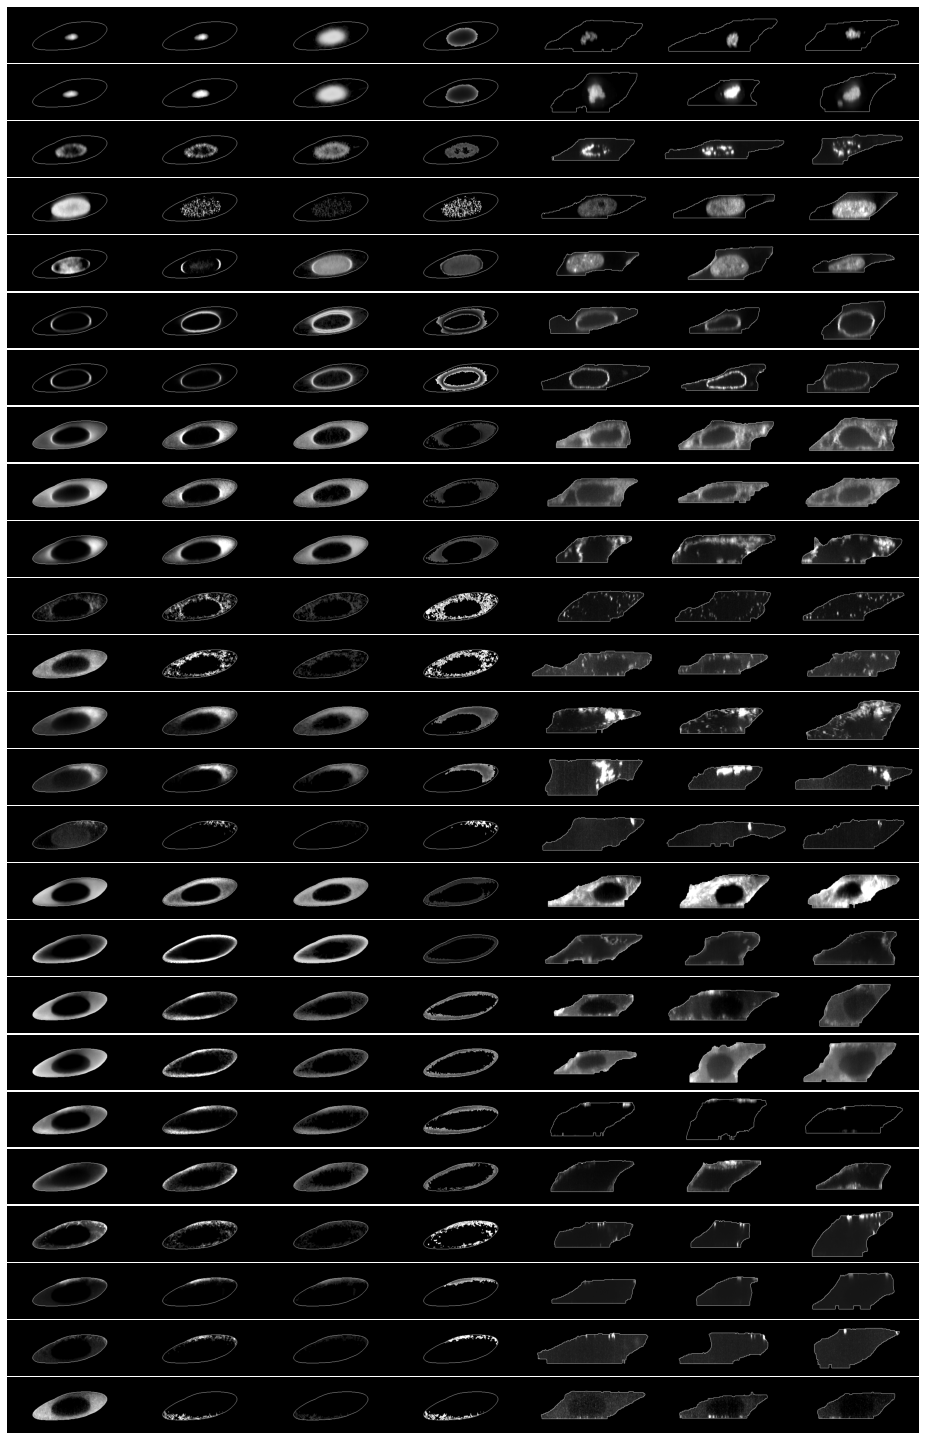

In [39]:
%matplotlib inline
mappoint = 7
nsamples = 3

fig, axs = plt.subplots(25,4+nsamples, figsize=((4+nsamples)*420/180,25*1.05),
                        gridspec_kw={'hspace': 0.0, 'wspace': 0.0},
                        sharey=True, sharex=True)

for sid, sname in tqdm(enumerate(
    ["FBL",
     "NPM1",
     "SON",
     "SMC1A",
     "HIST1H2BJ",
     "LMNB1" ,
     "NUP153" ,
     "SEC61B",
     "ATP2A2" ,
     "TOMM20",
     "SLC25A17",
     "RAB5A",
     "LAMP1",
     "ST6GAL1",
     "CETN2",
     "TUBA1B",
     "AAVS1",
     "ACTN1",
     "ACTB",
     "MYH10",
     "CTNNB1",
     "GJA1",
     "TJP1",
     "DSP",
     "PXN"]), total=25):
    # Show agg cells
    axs[sid,0].imshow(get_projection_of_agg_cell(avg_gfp, sname, mappoint=mappoint, contrast_config=contrasts_avg_gfp), origin='lower', cmap='gray')
    axs[sid,0].axis('off')
    axs[sid,1].imshow(get_projection_of_agg_cell(avg_seg, sname, mappoint=mappoint), origin='lower', cmap='gray')
    axs[sid,1].axis('off')
    axs[sid,2].imshow(get_projection_of_agg_cell(std_seg, sname, mappoint=mappoint, vrange=(0,150)), origin='lower', cmap='gray')
    axs[sid,2].axis('off')
    axs[sid,3].imshow(get_projection_of_agg_cell(cva_seg, sname, mappoint=mappoint, vrange=(0,10)), origin='lower', cmap='gray')
    axs[sid,3].axis('off')
    # Show examples
    df_sub = df.loc[df.index.isin(bin_indexes[mappoint][1])&(df.structure_name==sname)]
    for ns, index in enumerate(cell_selection[sname][0]):
        row = df_sub.loc[index]
        raw = AICSImage(row.crop_raw).data.squeeze()
        seg = AICSImage(row.crop_seg).data.squeeze()
        # Perform 2d alignment
        seg, params = shtools.align_image_2d(image=seg, alignment_channel=1, preserve_chirality=True)
        # Apply alignemnt to raw data
        raw = shtools.apply_image_alignment_2d(
            image = raw,
            angle = params[0],
            flip_x = int(params[1]),
            flip_y = int(params[2])
        )
        # Make projection and plot
        seg_proj, raw_proj = get_projection(seg=seg, raw=raw, sname=sname, rad=cell_selection[sname][1])
        axs[sid,4+ns].imshow(raw_proj[2], origin='lower', cmap='gray')
        axs[sid,4+ns].axis('off')
        
plt.savefig(f'{out}/agg_vs_real_seg_selected.tif', dpi=150)
plt.show()

In [41]:
out

'/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cell_shape_variation/local_staging/notebooks/fig_cytoparam'

# Examples of morphed cells

In [533]:
# Create map points, bins e get all cells in each bin
_, bin_indexes, _ = avgshape.digitize_shape_mode(
    df = df,
    feature = 'DNA_MEM_PC1',
    nbins = 9
)

In [635]:
folder_morph_instances = '/allen/aics/assay-dev/MicroscopyOtherData/Viana/forOthers/Morph_PRODUCTION/instances'

sname = 'TOMM20'
selected_bin = 4
img_type = 'raw'

available_morphed_cells = []
for index in tqdm(bin_indexes[selected_bin][1]):
    if df.at[index,'structure_name'] == sname:
        if os.path.exists(os.path.join(folder_morph_instances,f'{index}_ShapeMode1_{img_type}_morph.tif')):
            available_morphed_cells.append(index)
print(f'Found {len(available_morphed_cells)} {img_type} morphed cells of {sname} in bin {selected_bin-5}')


Found 256 raw morphed cells of TOMM20 in bin -1


In [636]:
for idx, index in enumerate(available_morphed_cells[:3]):
        
    img = AICSImage(os.path.join(folder_morph_instances,f'{index}_ShapeMode1_{img_type}_morph.tif')).data.squeeze()
    
    img = img[:,:,ymid-6:ymid+6].max(axis=2)
    img[0]*=255
    img[1]*=255
    img = img[:,::-1]
    
    writer = writers.OmeTiffWriter(f'{out}/{index}_{img_type}.tif', overwrite_file=True)
    writer.save(img, dimension_order='ZYX')

In [629]:
img.shape

(3, 124, 248)

In [624]:
img.shape

(3, 124, 140, 248)